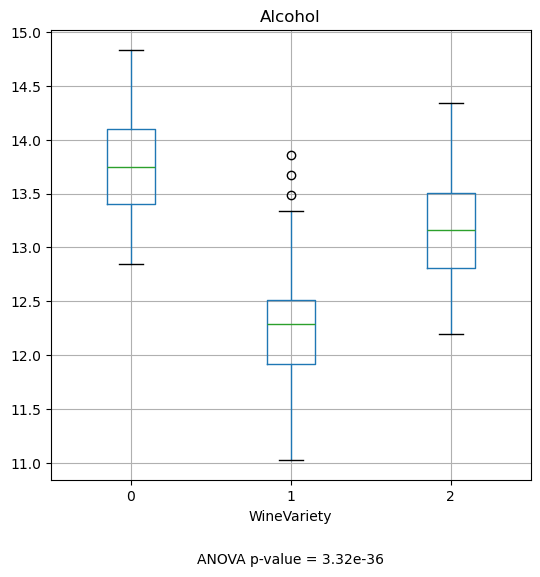

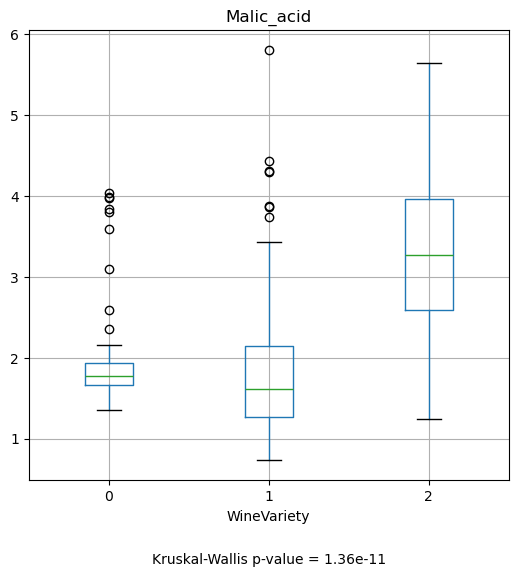

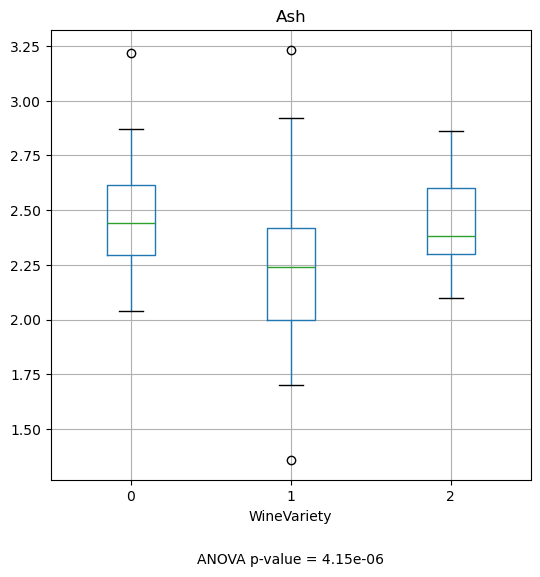

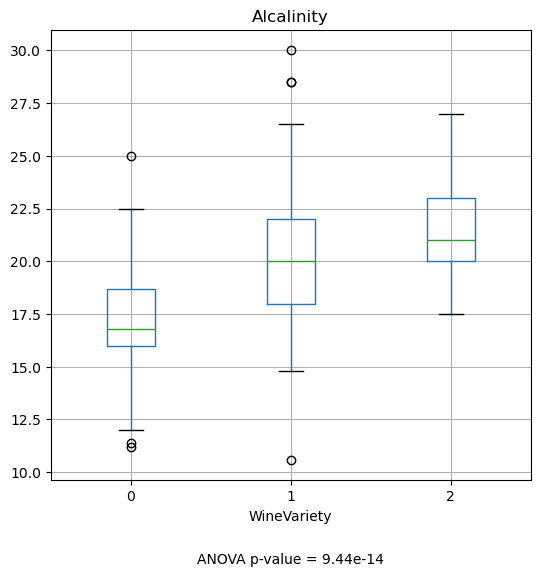

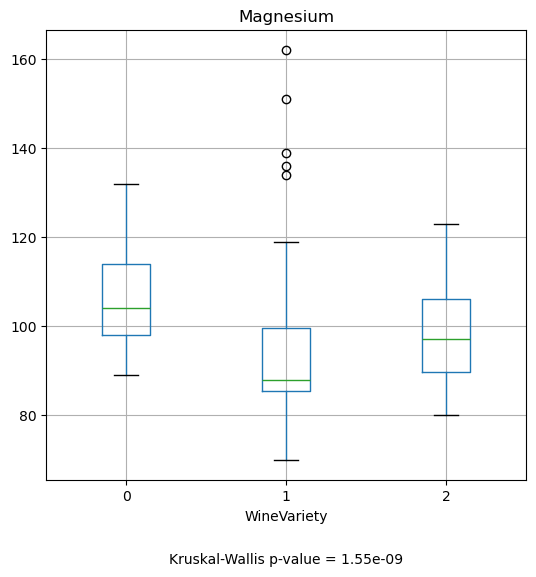

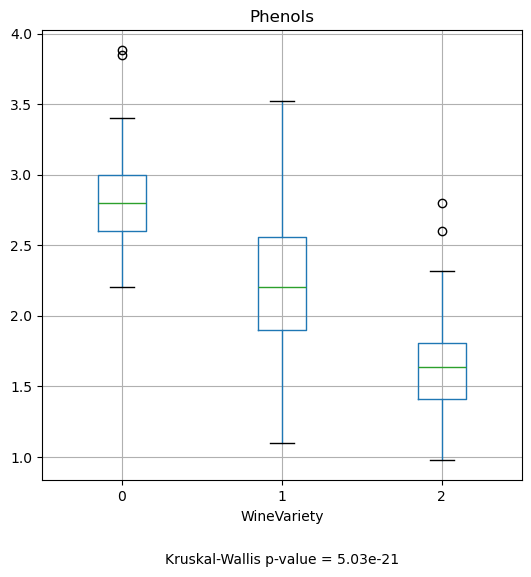

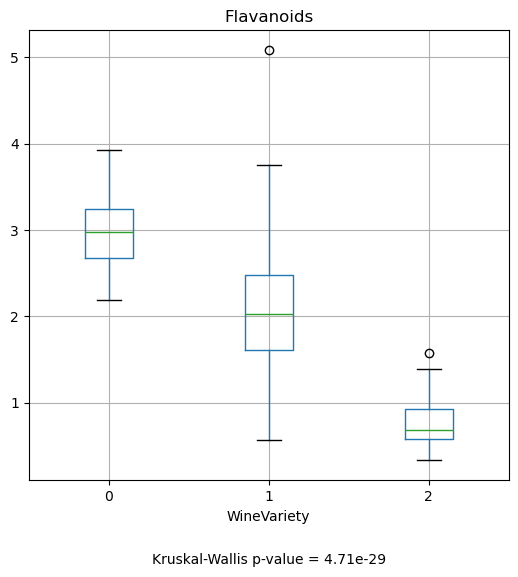

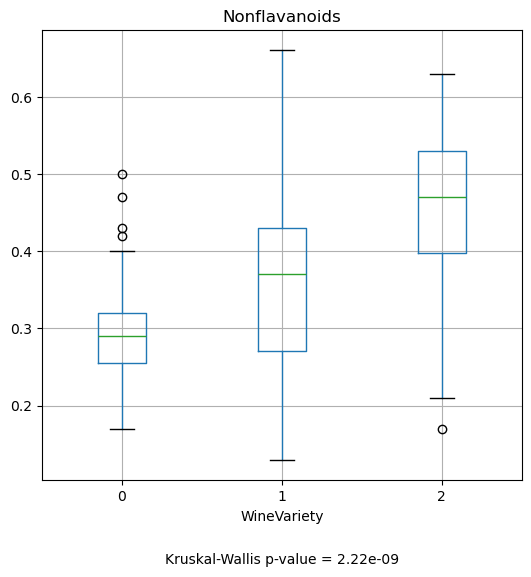

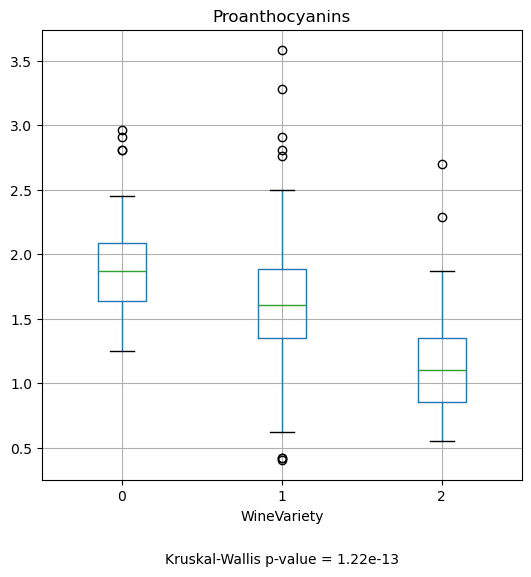

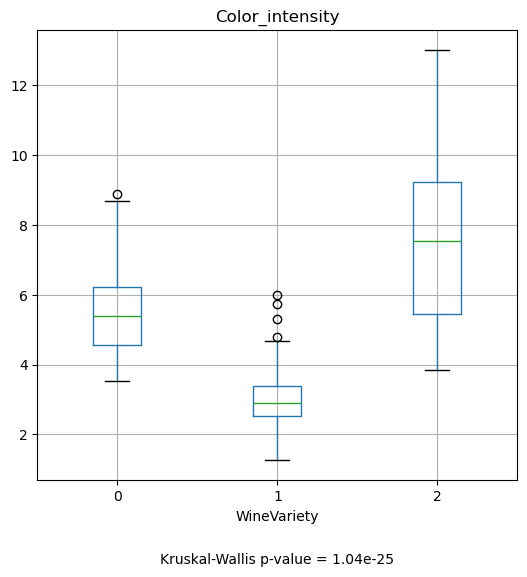

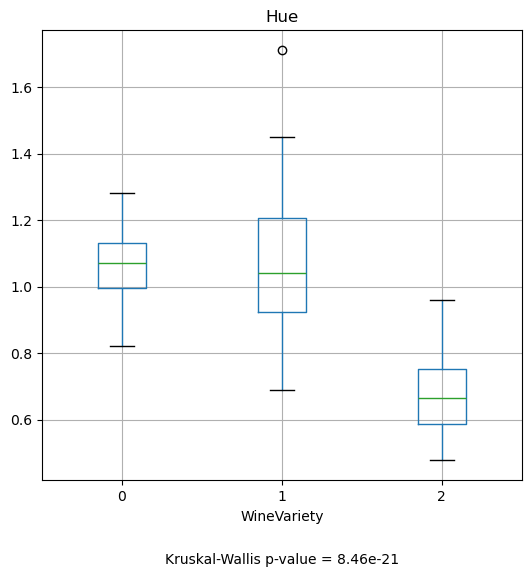

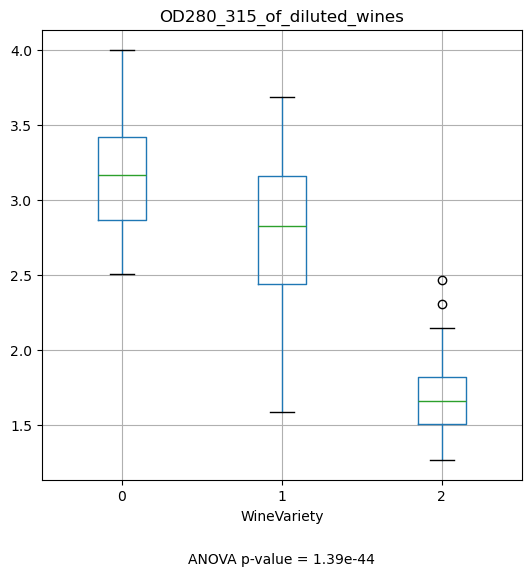

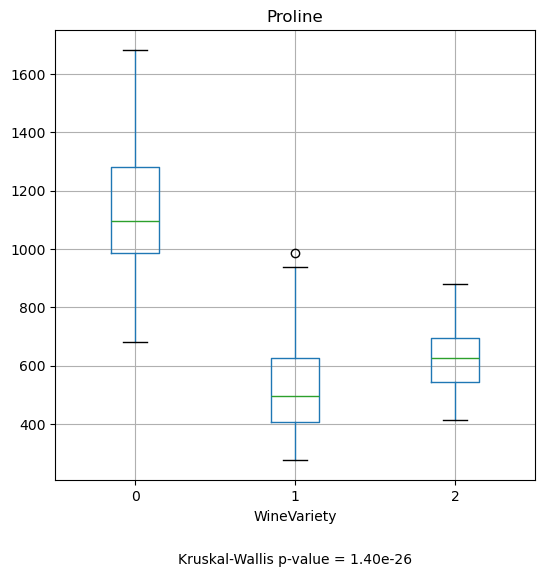

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Log Loss: 0.03586241424749671


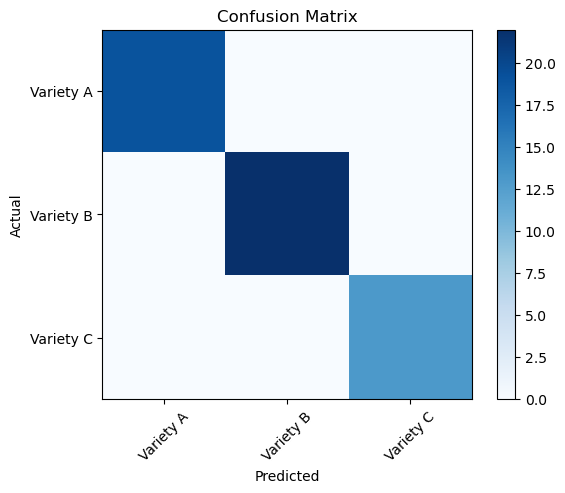

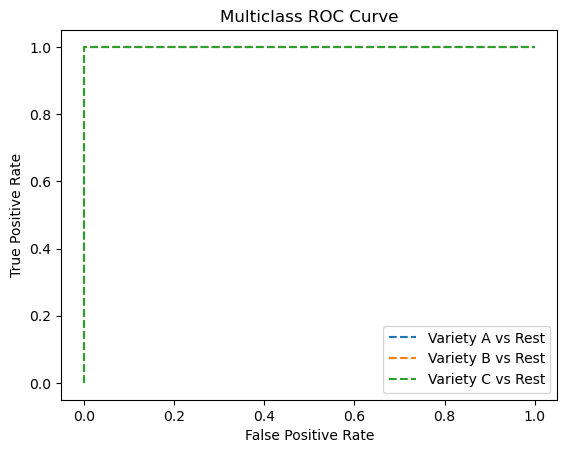

AUC: 1.0
0 (Variety A)
1 (Variety B)


'\n📌 Model Comparison Note:\n- Two model types were tested: baseline logistic regression and L2-regularized logistic regression (Ridge).\n- Both achieved 100% accuracy on the test set, but baseline had slightly lower log loss, indicating more confident predictions.\n- Therefore, baseline model was retained for deployment.\n- Switching between models is possible via `model_type` variable.\n'

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f_oneway, kruskal, shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, roc_auc_score, roc_curve
import joblib

# --- Load data ---
data = pd.read_csv('wine.csv')
features = ['Alcohol','Malic_acid','Ash','Alcalinity','Magnesium','Phenols',
            'Flavanoids','Nonflavanoids','Proanthocyanins','Color_intensity',
            'Hue','OD280_315_of_diluted_wines','Proline']
label = 'WineVariety'
X, y = data[features].values, data[label].values

# --- Exploratory Analysis ---
classes = ['Variety A', 'Variety B', 'Variety C']

for col in features:
    data.boxplot(column=col, by='WineVariety', figsize=(6,6))
    plt.title(f'{col}')
    plt.suptitle("")

    # Statistical test: ANOVA or Kruskal-Wallis
    groups = [data[data['WineVariety'] == i][col] for i in range(3)]
    normality = all(shapiro(g)[1] > 0.05 for g in groups)
    if normality:
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"

    plt.figtext(0.5, 0.01, f"{test_used} p-value = {p:.2e}", ha="center")
    plt.show()

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# --- Preprocessing ---
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), list(range(X.shape[1])))
])

# --- Model selection switch ---
model_type = 'baseline'  # Options: 'baseline', 'ridge'

if model_type == 'baseline':
    classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
elif model_type == 'ridge':
    classifier = LogisticRegressionCV(penalty='l2', solver='lbfgs', multi_class='multinomial', cv=5, max_iter=1000)
else:
    raise ValueError("Invalid model_type. Use 'baseline' or 'ridge'.")

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# --- Train model ---
model = pipeline.fit(X_train, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_prob))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(3), classes, rotation=45)
plt.yticks(np.arange(3), classes)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr, tpr = {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{classes[i]} vs Rest')

plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:', roc_auc_score(y_test, y_prob, multi_class='ovr'))

# --- Save model ---
#joblib.dump(model, 'wine_classifier.pkl')

# --- Example prediction ---
x_new = np.array([[13.72,1.43,2.5,16.7,108,3.4,3.67,0.19,2.04,6.8,0.89,2.87,1285],
                  [12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520]])

predictions = model.predict(x_new)
for prediction in predictions:
    print(prediction, '(' + classes[prediction] + ')')

"""
📌 Model Comparison Note:
- Two model types were tested: baseline logistic regression and L2-regularized logistic regression (Ridge).
- Both achieved 100% accuracy on the test set, but baseline had slightly lower log loss, indicating more confident predictions.
- Therefore, baseline model was retained for deployment.
- Switching between models is possible via `model_type` variable.
"""